## Детектирование сигнала светофора

Проект направлен на обнаружение сигнала светофора с использованием машинного обучения
Задачи:
- Обнаружение красного (круглого) сигнала в дневное время
- Обнаружение желтого (круглого) сигнала в дневное время
- Обнаружение зеленого (круглого) сигнала в дневное время
- Детектирование отсутствия светофора в дневное время

Для проекта используются следующие датасеты:
- тренировочный (4 датасета: red, yellow, green, empty - без светофора)
-  тестовый  (4 датасета: red, yellow, green, empty - без светофора)

Каждый датасет представляет собой набор изображений с трехсекционным светофором в дневное время (для набора empty - без светофора в дневное время).

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [2]:
!wget https://www.dropbox.com/s/85srzvwk1owrr5t/train_cut.zip?dl=0  -O train_cut.zip

--2023-01-18 09:58:34--  https://www.dropbox.com/s/85srzvwk1owrr5t/train_cut.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/85srzvwk1owrr5t/train_cut.zip [following]
--2023-01-18 09:58:35--  https://www.dropbox.com/s/raw/85srzvwk1owrr5t/train_cut.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc62e2a168e673cb8801cb791c92.dl.dropboxusercontent.com/cd/0/inline/B0x0edUIKky5IfHSqE70ZMwj-0LwGM1yoVsztOnT2Rr7s52mD7QQAEiL8pp70Ys58KgcMIFdmbgz8euO5_qtBQV7iqMTX-u_OTQjLt2aUNhPAf9_gmWceY31aHOSvYWBBAtBDdaOdrQx-DRv3K0iNQr0IzC-0H1oZEWj0svfWRIlOg/file# [following]
--2023-01-18 09:58:35--  https://uc62e2a168e673cb8801cb791c92.dl.dropboxusercontent.com/cd/0/inline/B0x0edUIKky5IfHSqE70ZMwj-0LwGM1yoVsztOnT2Rr7s52mD7QQAEiL8pp70Ys58KgcMI

In [3]:
!wget https://www.dropbox.com/s/p7kniyf6fige4eq/test_cut.zip?dl=0 -O test_cut.zip

--2023-01-18 09:58:38--  https://www.dropbox.com/s/p7kniyf6fige4eq/test_cut.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/p7kniyf6fige4eq/test_cut.zip [following]
--2023-01-18 09:58:39--  https://www.dropbox.com/s/raw/p7kniyf6fige4eq/test_cut.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9210f96b8ba6f59ead4b5d3d27.dl.dropboxusercontent.com/cd/0/inline/B0z-FXbzX9Ip63c9BdsZdLYvDLGGZEM6d1tGcfmSLgPqrasOo4q5taiN_v_ehEweIAnYvHX7a9kvNthg_pGb7kAOdsie2_H_hoWYBpejN7hzmdie2MdECArA0pfNaAVeiWyX2gf8NUfwOr_ujy9XF_CzW9jh_iFwptTjbWvo_QqYrQ/file# [following]
--2023-01-18 09:58:40--  https://uc9210f96b8ba6f59ead4b5d3d27.dl.dropboxusercontent.com/cd/0/inline/B0z-FXbzX9Ip63c9BdsZdLYvDLGGZEM6d1tGcfmSLgPqrasOo4q5taiN_v_ehEweIAnYvHX7a

In [4]:
!ls

sample_data  test_cut.zip  train_cut.zip


In [6]:
!unzip -q train_cut.zip

In [7]:
!ls train_cut

green  red


In [8]:
!unzip -q test_cut.zip

In [9]:
!ls test_cut

green  red


In [13]:
train_path='train_cut'
test_path='test_cut'

Смотрим примеры картинок

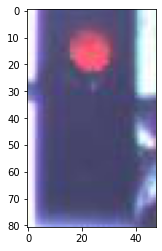

In [14]:
img_path = f'{train_path}/red/ds1_pic1349.jpg'
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

## Создаем наборы данных

Набор данных для обучения

In [16]:
train_dataset = image_dataset_from_directory(f'{train_path}',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 2000 files belonging to 2 classes.


In [17]:
class_names = train_dataset.class_names

In [18]:
class_names

['green', 'red']

Набор данных для тестирования

In [19]:
test_dataset = image_dataset_from_directory(f'{test_path}',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 2000 files belonging to 2 classes.


## Создаем составную нейронную сеть

In [20]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [21]:
inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
# num_classes = 3 # Задаем количество классов
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

16705208/16705208 [==============================] - 0s 0us/step


Компилируем составную нейронную сеть

In [22]:
# Для задачи с двумя классами изображений
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

## Обучаем сеть

In [ ]:
history = model.fit(train_dataset,
                    epochs=10)

Epoch 1/10


16/16 [==============================] - 53s 2s/step - loss: 0.5750 - accuracy: 0.7240
Epoch 2/10
16/16 [==============================] - 34s 2s/step - loss: 0.2491 - accuracy: 0.9060
Epoch 3/10
 6/16 [==========>...................] - ETA: 21s - loss: 0.1714 - accuracy: 0.9414

Проверяем качество обучения на тестовом наборе данных


In [ ]:
scores = model.evaluate(test_dataset, verbose=1)

In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

## Использование нейронной сети для распознавания изображений

Вспоминаем номера классов

In [ ]:
class_names

Загружаем изображение из файла

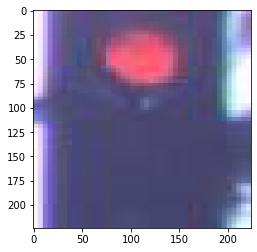

In [15]:
img_path = f'{test_path}/red/ds1_pic1147.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [ ]:
prediction = model.predict(x)

Печатаем результаты распознавания

In [ ]:
prediction


array([[0.9814932]], dtype=float32)